### Try to define ENSO 3.4 index in a "simple" way

Following https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni and using the NINO3.4 box, we can diagnose the El-Nino-Southern-Oscillation Index (ENSO) from sea-surface temperature (SST). 

Computation recipe in detail: 
- Compute area averaged total SST from Niño 3.4 region.
- Compute monthly climatology for area averaged total SST from Niño 3.4 region.
- Subtract climatology from area averaged total SST time series to obtain anomalies. 
- Smooth the anomalies with a 5-month running mean.
- Normalize the smoothed values by its standard deviation over the climatological period.

This recipe for calculating ENSO requires some rolling mean. We omit the rolling mean here and directly take **sst anomaly index** instead. And as climatology we use the full time span.

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import xarray as xr
from climate_index_collection.data_loading import (
    find_data_files,
    load_data_set,
)
from climate_index_collection.indices import (
    north_atlantic_oscillation_pc,
    north_atlantic_oscillation,
    southern_annular_mode,
)
from climate_index_collection.data_loading import load_and_preprocess_single_data_file

In [51]:
FOCI_alldata = load_data_set(data_path="../data/test_data/", data_source_name="FOCI")
CESM_alldata = load_data_set(data_path="../data/test_data/", data_source_name="CESM")

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [10]:
nao_station = north_atlantic_oscillation(data_set=FOCI_alldata, slp_name='sea-level-pressure')
nao_pc = north_atlantic_oscillation_pc(data_set=FOCI_alldata, slp_name='sea-level-pressure')

<function matplotlib.pyplot.show(close=None, block=None)>

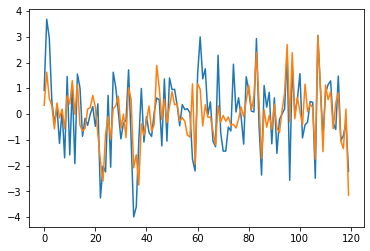

In [14]:
plt.plot(nao_station.values)
plt.plot(-nao_pc.values)
plt.show

In [20]:
np.corrcoef(np.stack([nao_station.values, nao_pc.values]))

array([[ 1.        , -0.71130364],
       [-0.71130364,  1.        ]])

In [23]:
load_and_preprocess_single_data_file?

Signature: load_and_preprocess_single_data_file(file_name, **kwargs)
Docstring:
Load and preprocess individual data file.

Current pre-processing steps:
- squeeze (to get rid of, e.g., some of the vertical degenerate dims)
- fixing monthly timestamps
- fixing start years

Parameters
----------
file_name: str or pathlike
    File name.

All kwargs will be passed on to xarray.open_dataset().

Returns
-------
xarray.Dataset
    Dataset.
File:      /work/climate_index_collection/data_loading.py
Type:      function


### Now compare NAO - station-based vs. pc-bases - with real-world slp-data

In [30]:
slp_real = xr.open_dataset("../data/raw/pres.sfc.mon.mean.nc")

In [34]:
slp_real.pres

<xarray.DataArray 'pres' (time: 887, lat: 73, lon: 144)>
[9324144 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-11-01
Attributes:
    long_name:     Monthly Mean of Surface Pressure
    valid_range:   [ 400. 1150.]
    units:         millibars
    precision:     2
    var_desc:      Surface Pressure
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Other
    dataset:       NCEP Reanalysis Derived Products
    actual_range:  [ 495.9276 1090.4432]

In [43]:
nao_station_real = north_atlantic_oscillation_singlefile(data_set=slp_real.pres)
nao_pc_real = north_atlantic_oscillation_pc_singlefile(data_set=slp_real.pres)

<function matplotlib.pyplot.show(close=None, block=None)>

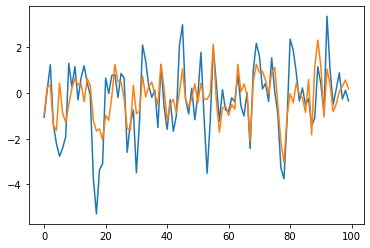

In [49]:
plt.plot(nao_station_real.values[-100:])
plt.plot(-nao_pc_real.values[-100:])
plt.show

In [45]:
np.corrcoef(np.stack([nao_station_real.values, nao_pc_real.values]))

array([[ 1.        , -0.78994393],
       [-0.78994393,  1.        ]])

In [41]:
def north_atlantic_oscillation_singlefile(data_set):
    """Calculate the station based North Atlantic Oscillation (NAO) index

    This uses station-based sea-level pressure closest to Reykjavik (64°9'N, 21°56'W) and
    Ponta Delgada (37°45'N, 25°40'W) and, largely following [Hurrel, 1995]
    <https://doi.org/10.1126/science.269.5224.676>, defines the north-atlantic oscillation index
    as the difference of normalized in Reykjavik and Ponta Delgada without normalizing the
    resulting timeseries again. (This means that the north atlantic oscillation presented here
    has vanishing mean because both minuend and subtrahend have zero mean, but no unit
    standard deviation.)

    Parameters
    ----------
    data_set: xarray.DataSet
        Dataset containing an SLP field.
    slp_name: str
        Name of the Sea-Level Pressure field. Defaults to "sea-level-pressure".

    Returns
    -------
    xarray.DataArray
        Time series containing the NAO index.

    """
    slp = data_set

    slp_northern_station = slp.sel(lat=64, lon=338, method="nearest")
    slp_southern_station = slp.sel(lat=38, lon=334, method="nearest")

    slp_northern_station_norm = (
        slp_northern_station - slp_northern_station.mean("time")
    ) / slp_northern_station.std("time")
    slp_southern_station_norm = (
        slp_southern_station - slp_southern_station.mean("time")
    ) / slp_southern_station.std("time")

    NAO_index = slp_northern_station_norm - slp_southern_station_norm
    NAO_index = NAO_index.rename("NAO")

    return NAO_index




In [42]:
def north_atlantic_oscillation_pc_singlefile(data_set):
    """Calculate the principal component based North Atlantic Oscillation (NAO) index

    Following
    https://climatedataguide.ucar.edu/climate-data/hurrell-north-atlantic-oscillation-nao-index-pc-based
    this index is obtained as Principle Component (PC) time series of the leading Empirical Orthogonal Function (EOF)
    of monthly sea-level pressure anomalies over the Atlantic sector, 20°-80°N, 90°W-40°E.

    Computation is done as follows:
    1. Compute sea level pressure anomalies over Atlantic sector.
    2. Flatten spatial dimensions and subtract mean in time.
    3. Perform Singular Value Decomposition.
    4. Normalize Principal Components.
    5. Obtain NAO index as PC time series related to leading EOF.

    Parameters
    ----------
    data_set: xarray.DataSet
        Dataset containing an SLP field.
    slp_name: str
        Name of the Sea-Level Pressure field. Defaults to "sea-level-pressure".

    Returns
    -------
    xarray.DataArray
        Time series containing the NAO index.

    """

    mask = (
        (data_set.coords["lat"] >= 20)
        & (data_set.coords["lat"] <= 80)
        & ((data_set.coords["lon"] >= 270) | (data_set.coords["lon"] <= 40))
    )

    slp = data_set.where(mask)
    climatology = slp.groupby("time.month").mean("time")
    slp = (slp.groupby("time.month") - climatology).drop("month")

    slp_flat = slp.stack(tmp_space=("lat", "lon")).dropna(dim="tmp_space")

    pc, s, eof = sp.linalg.svd(slp_flat - slp_flat.mean(axis=0), full_matrices=False)

    pc_std = pc.std(axis=0)
    pc /= pc_std

    NAO_index = xr.DataArray(pc[:, 0], dims=("time"), coords={"time": slp_flat["time"]})

    NAO_index = NAO_index.rename("NAO_PC")

    return NAO_index

### Now implement SAM pc-based

In [56]:
sam = southern_annular_mode(data_set=FOCI_alldata, slp_name='sea-level-pressure')
sam_pc = southern_annular_mode_pc(data_set=FOCI_alldata, slp_name='sea-level-pressure')

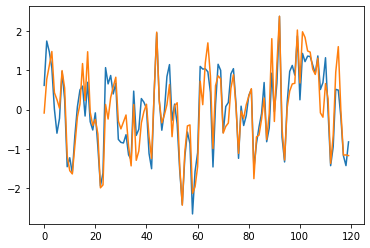

In [57]:
plt.plot(sam.values)
plt.plot(sam_pc.values)

In [58]:
np.corrcoef(np.stack([sam.values, sam_pc.values]))

array([[1.       , 0.9127407],
       [0.9127407, 1.       ]])

In [54]:
def southern_annular_mode_pc(data_set, slp_name="sea-level-pressure"):
    """Calculate the principal component based southern annular mode (SAM) index.

    This index is obtained as Principle Component (PC) time series of the leading Empirical Orthogonal Function (EOF)
    of monthly sea-level pressure over the Southern hemisphere.
    
    Computation is done as follows:
    1. Take sea level pressure over Southern hemisphere.
    2. Flatten spatial dimensions and subtract mean in time.
    3. Perform Singular Value Decomposition.
    4. Normalize Principal Components.
    5. Obtain SAM index as PC time series related to leading EOF.
    
    Parameters
    ----------
    data_set: xarray.DataSet
        Dataset containing a SLP field.
    slp_name: str
        Name of the Sea-Level Pressure field. Defaults to "sea-level-pressure".

    Returns
    -------
    xarray.DataArray
        Time series containing the SAM index.

    """

    mask = (data_set.coords["lat"] <= 0)

    slp = data_set[slp_name].where(mask)
    
    slp_flat = slp.stack(tmp_space=("lat", "lon")).dropna(dim="tmp_space")

    pc, s, eof = sp.linalg.svd(slp_flat - slp_flat.mean(axis=0), full_matrices=False)

    pc_std = pc.std(axis=0)
    pc /= pc_std

    SAM_index = xr.DataArray(pc[:, 0], dims=("time"), coords={"time": slp_flat["time"]})
    
    SAM_index = SAM_index.rename("SAM_PC")

    return SAM_index
